# Statistical Analysis of Irrigation Values Inside and Outside Dam Command Areas (1980 - 2015)

This notebook performs descriptive statistics, visualizations, and hypothesis testing on
irrigation pixel values extracted from inside and outside dam command areas for the years
1980–2015.

**Outline:**
1. Setup and Configuration
2. Data Ingestion and Preprocessing
3. Pixel Classification (Inside vs. Outside)
4. Descriptive Statistics
5. Distribution Visualization
6. Hypothesis Testing and Effect Sizes
7. Bootstrap Confidence Intervals
8. Summary Figures Over Time
9. Interpretation Aids

### 1. Setup and Configuration

In [1]:
# Core Imports
import os, sys, warnings
from itertools import product
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from tqdm import tqdm
import rasterio
from rasterio.mask import mask
from rasterio.io import MemoryFile

# Custom Utility Imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from Code.utils.utility import load_config, resolve_path
from Code.utils.spatial_utility import load_raster_and_reproject

warnings.filterwarnings("ignore")
config = load_config()

### 2. Data Loading and Preprocessing

In [2]:
def load_irrigation_arrays(years, config):
    arrays = {}
    for year in years:
        path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
        with rasterio.open(path) as src:
            arrays[year] = src.read(1)
    return arrays

years = [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]
irrigation_arrays = load_irrigation_arrays(years, config)

### 3. Pixel Classification: Inside vs. Outside Command Areas

In [3]:
def extract_inside_outside_pixels(year, ca_gdf, raster_path):
    arr_reproj, transform, meta = load_raster_and_reproject(raster_path, target_crs="EPSG:4326")
    meta.update({"height": arr_reproj.shape[0], "width": arr_reproj.shape[1],
                 "transform": transform, "crs": "EPSG:4326", "count": 1, "dtype": arr_reproj.dtype})
    with MemoryFile() as memfile:
        with memfile.open(**meta) as src:
            src.write(arr_reproj, 1)
            in_mask, _ = mask(src, ca_gdf.geometry, crop=False, invert=False, nodata=src.nodata)
            out_mask, _ = mask(src, ca_gdf.geometry, crop=False, invert=True, nodata=src.nodata)
            in_vals = in_mask[0][(in_mask[0] != src.nodata) & (in_mask[0] != -9)]
            out_vals = out_mask[0][(out_mask[0] != src.nodata) & (out_mask[0] != -9)]
            return in_vals, out_vals, arr_reproj

inside_pixels_dict, outside_pixels_dict, results = {}, {}, []
ca_dir = resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path'])

for year in years:
    ca_path = os.path.join(ca_dir, f'merged_CA_{year}.shp')
    ca_gdf = gpd.read_file(ca_path).to_crs("EPSG:4326")
    raster_path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
    inside, outside, arr = extract_inside_outside_pixels(year, ca_gdf, raster_path)
    inside_pixels_dict[year], outside_pixels_dict[year] = inside, outside
    all_valid = arr[(arr != -9) & (~np.isnan(arr))]
    results.append({"Year": year, "Total Inside": np.nansum(inside), "Total Outside": np.nansum(outside),
                    "Total (Check)": np.nansum(all_valid),
                    "Inside + Outside == Total": np.isclose(np.nansum(inside) + np.nansum(outside), np.nansum(all_valid), atol=1e-3)})
results_df = pd.DataFrame(results)
display(Markdown("### Pixel Classification Results"))
display(results_df)

### Pixel Classification Results

,Year,Total Inside,Total Outside,Total (Check),Inside + Outside == Total
0,1980,146583.312500,3626157.75,3772740.75,True
1,1985,155394.953125,3886489.00,4041884.00,True
2,1990,179951.109375,4193189.00,4373140.00,True
3,1995,191177.234375,4589562.00,4780739.00,True
4,2000,213100.953125,4988758.00,5201859.50,True
5,2005,223731.078125,5015999.00,5239730.00,True
6,2010,227491.968750,5426327.00,5653819.00,True
7,2015,224764.500000,5534487.00,5759251.00,True


### 4. Descriptive Statistics

In [4]:
def compute_summary_stats(arr):
    arr = arr[~np.isnan(arr)]
    return {
        "Mean": np.mean(arr), "Median": np.median(arr), "Std": np.std(arr),
        "Variance": np.var(arr), "Min": np.min(arr), "Q1": np.percentile(arr, 25),
        "Q3": np.percentile(arr, 75), "Max": np.max(arr)
    }

desc_stats = []
for year in years:
    for group, data in [("Inside", inside_pixels_dict[year]), ("Outside", outside_pixels_dict[year])]:
        stats = compute_summary_stats(data)
        stats.update({'Year': year, 'Group': group})
        desc_stats.append(stats)
df_desc = pd.DataFrame(desc_stats)
display(Markdown("### Descriptive Statistics (by Year & Group)"))
display(df_desc)

### Descriptive Statistics (by Year & Group)

,Mean,Median,Std,Variance,Min,Q1,Q3,Max,Year,Group
0,321.454620,0.0,716.780579,513774.375000,0.0,0.0,175.071152,5325.664062,1980,Inside
1,19.527807,0.0,209.430649,43861.199219,0.0,0.0,0.000000,5679.717773,1980,Outside
2,319.742706,0.0,721.329346,520316.062500,0.0,0.0,174.318146,5591.004883,1985,Inside
3,20.933142,0.0,219.664856,48252.648438,0.0,0.0,0.000000,5900.110840,1985,Outside
4,285.636688,0.0,700.452698,490633.968750,0.0,0.0,143.594601,5700.501953,1990,Inside
5,22.602600,0.0,230.067596,52931.097656,0.0,0.0,0.000000,6073.035156,1990,Outside
6,302.975006,0.0,735.571289,541065.125000,0.0,0.0,149.586853,5700.501953,1995,Inside
7,24.739307,0.0,249.453995,62227.292969,0.0,0.0,0.000000,7504.132812,1995,Outside
8,321.904755,0.0,811.898560,659179.312500,0.0,0.0,130.577465,5700.501953,2000,Inside
9,26.895603,0.0,259.673615,67430.390625,0.0,0.0,0.000000,7504.132812,2000,Outside


### 5. Distribution Visualization

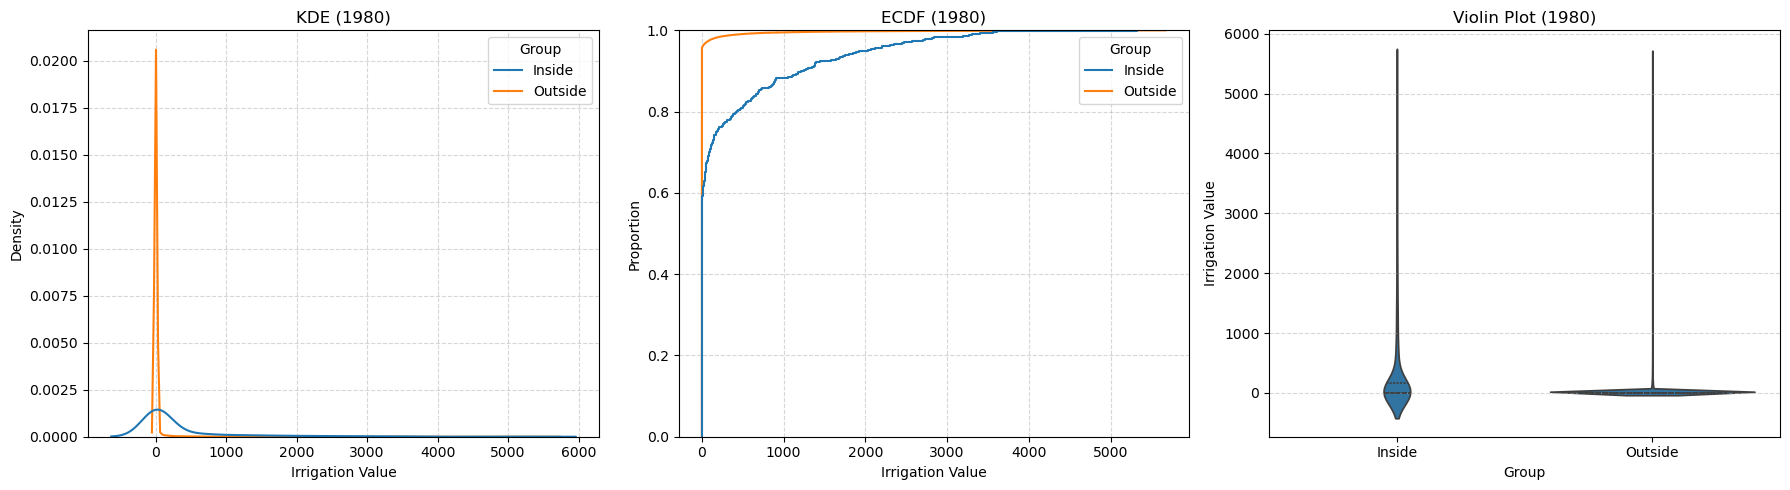

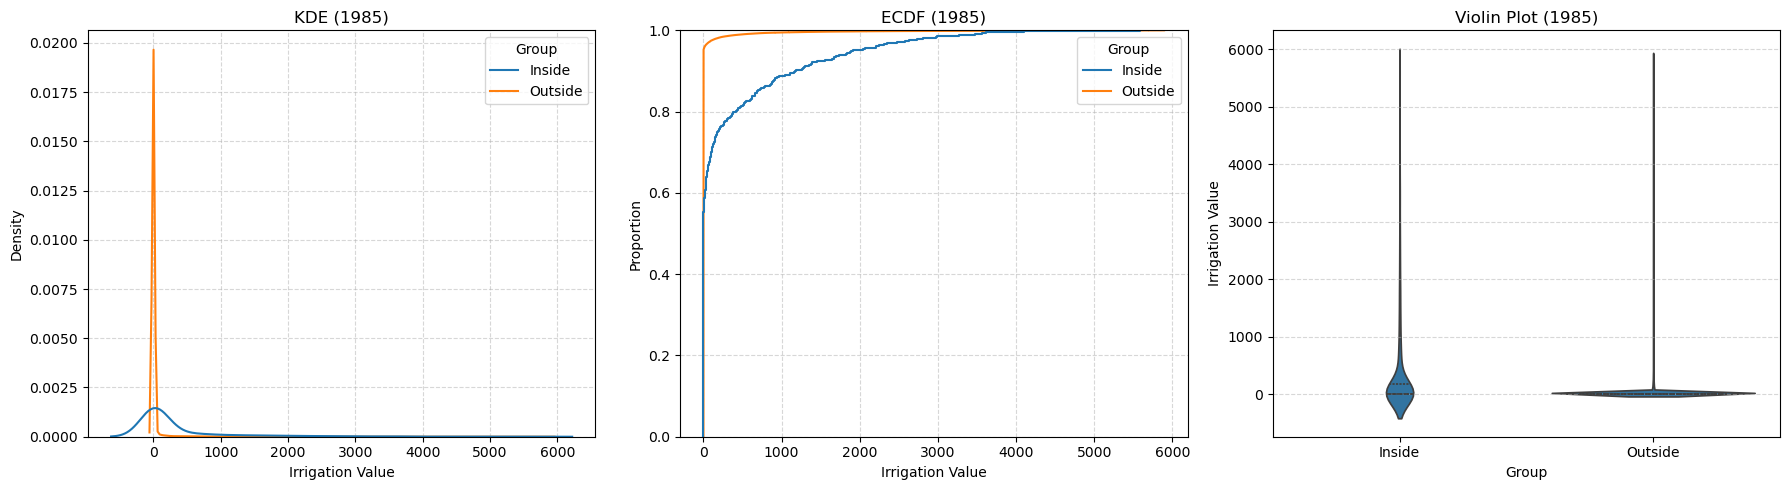

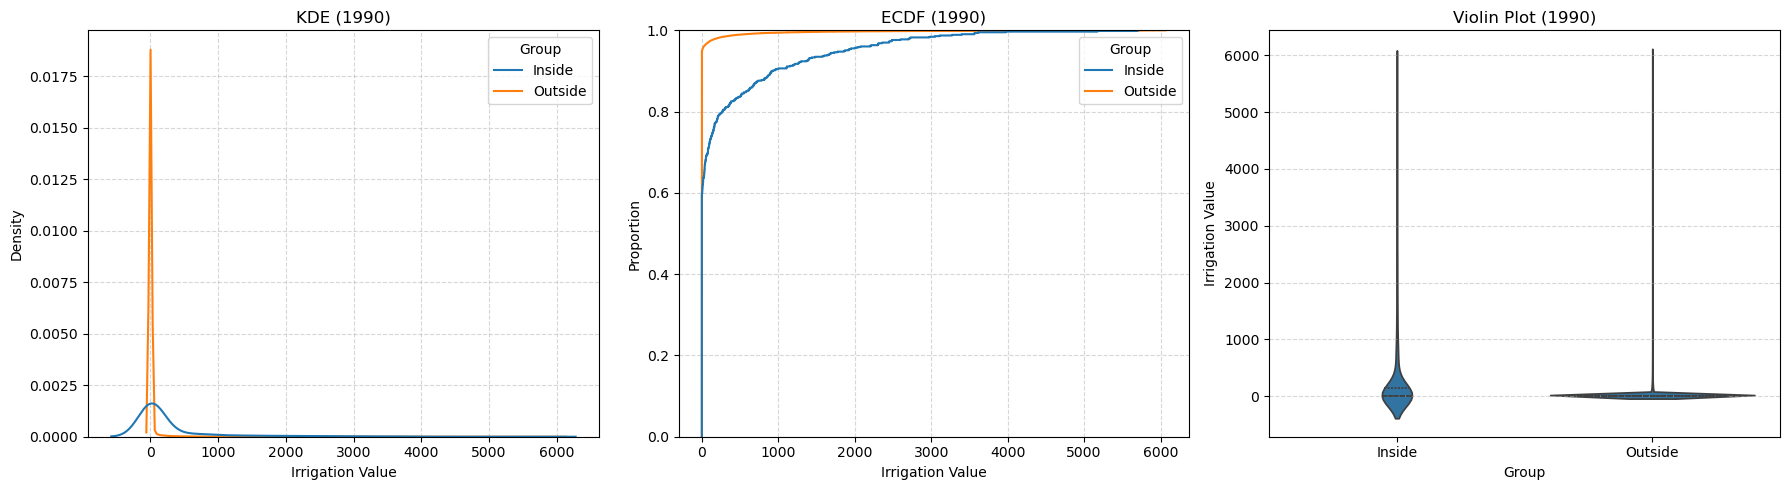

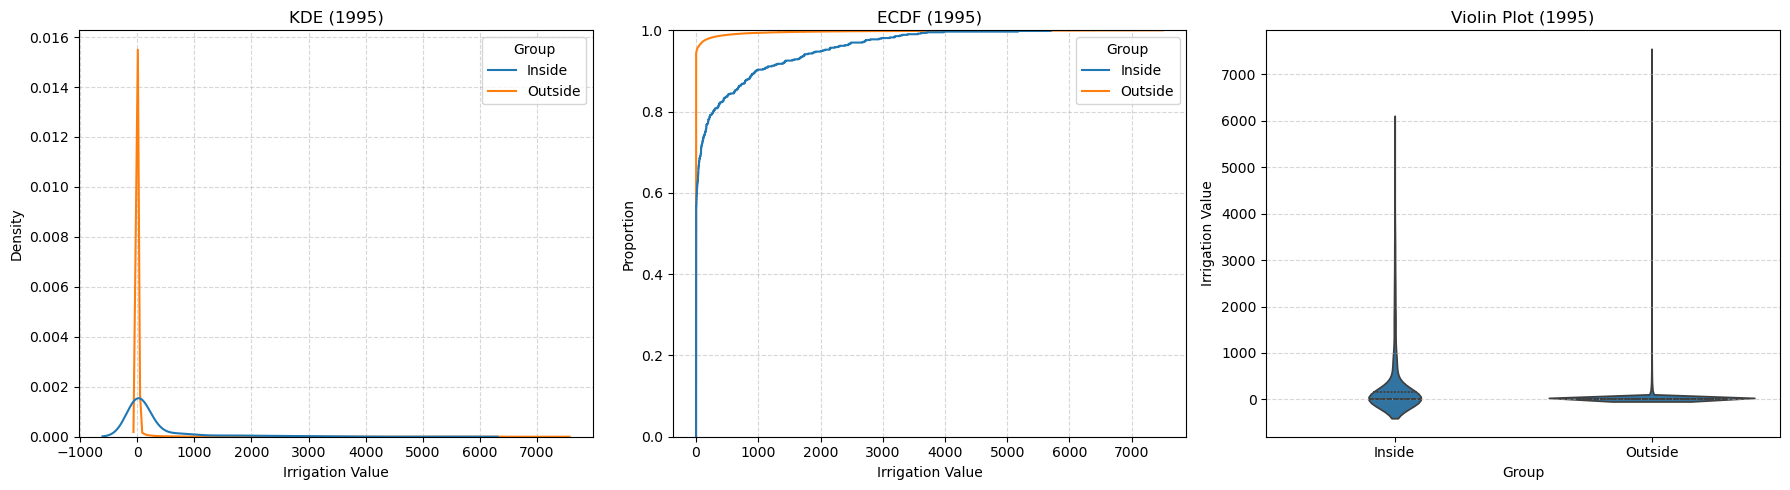

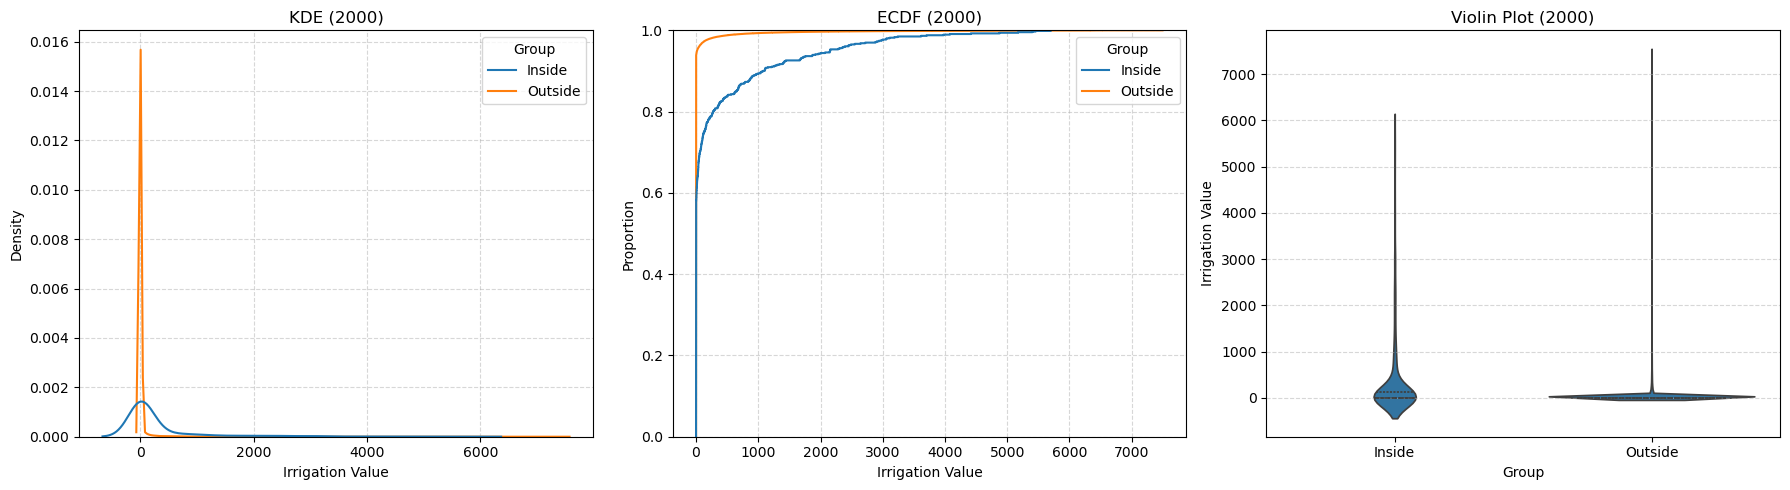

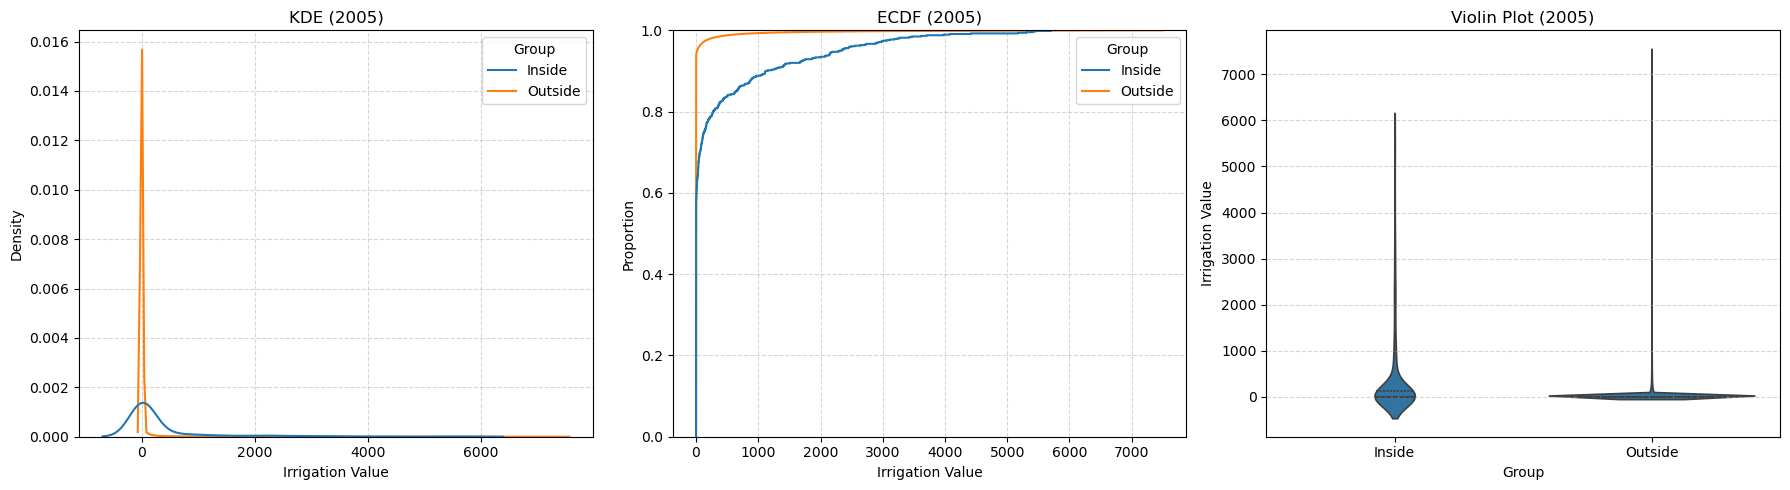

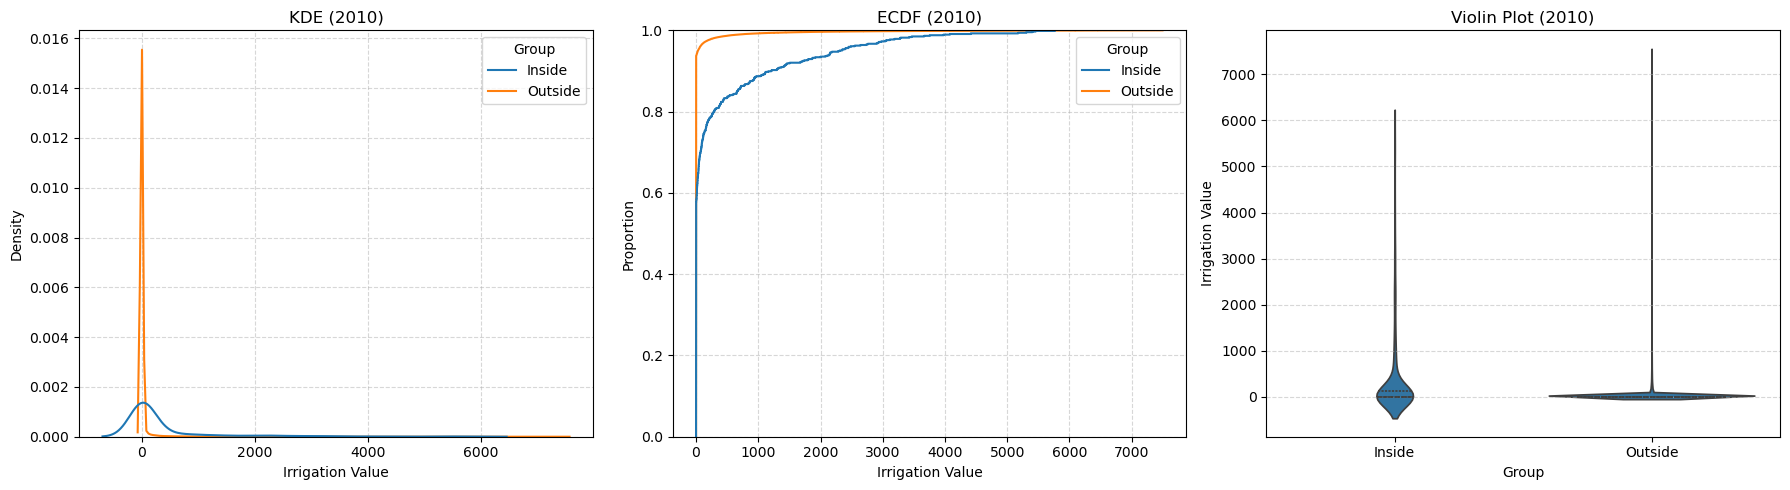

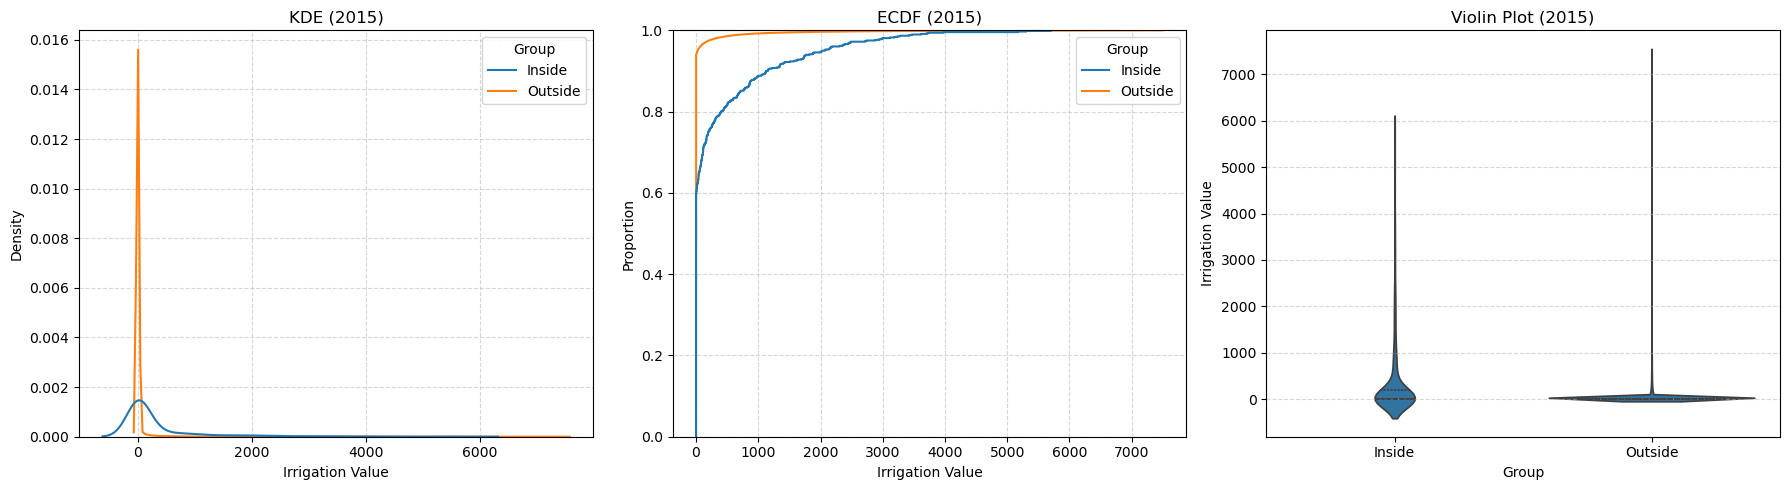

In [5]:
def plot_distributions(inside_arr, outside_arr, label, style="full"):
    inside_df = pd.DataFrame({'irrigation_value': inside_arr[~np.isnan(inside_arr)], 'Group': 'Inside'})
    outside_df = pd.DataFrame({'irrigation_value': outside_arr[~np.isnan(outside_arr)], 'Group': 'Outside'})
    combined_df = pd.concat([inside_df, outside_df])

    if style == "compact":
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # KDE
        sns.kdeplot(data=combined_df, x="irrigation_value", hue="Group", ax=axes[0], common_norm=False)
        axes[0].set_title(f"KDE ({label})")
        axes[0].set_xlabel("Irrigation Value")
        axes[0].grid(True, linestyle="--", alpha=0.5)

        # ECDF
        sns.ecdfplot(data=combined_df, x="irrigation_value", hue="Group", ax=axes[1])
        axes[1].set_title(f"ECDF ({label})")
        axes[1].set_xlabel("Irrigation Value")
        axes[1].grid(True, linestyle="--", alpha=0.5)

        # Violin plot
        sns.violinplot(data=combined_df, x="Group", y="irrigation_value", inner="quart", ax=axes[2])
        axes[2].set_title(f"Violin Plot ({label})")
        axes[2].set_ylabel("Irrigation Value")
        axes[2].grid(True, axis='y', linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()

    elif style == "full":
        # --- Figure 1: Histogram, KDE, ECDF ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Histogram
        sns.histplot(inside_df['irrigation_value'], stat="density", bins=100, color='blue', label='Inside', alpha=0.6, ax=axes[0])
        sns.histplot(outside_df['irrigation_value'], stat="density", bins=100, color='red', label='Outside', alpha=0.6, ax=axes[0])
        axes[0].set_title(f'Irrigation Histogram ({label})')
        axes[0].set_xlabel("Irrigation Value")
        axes[0].set_ylabel("Density")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", alpha=0.5)

        # KDE
        sns.kdeplot(inside_df['irrigation_value'], label='Inside', color='blue', ax=axes[1])
        sns.kdeplot(outside_df['irrigation_value'], label='Outside', color='red', ax=axes[1])
        axes[1].set_title(f'Irrigation KDE ({label})')
        axes[1].set_xlabel("Irrigation Value")
        axes[1].set_ylabel("Density")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", alpha=0.5)

        # ECDF
        sns.ecdfplot(inside_df['irrigation_value'], label='Inside', color='blue', ax=axes[2])
        sns.ecdfplot(outside_df['irrigation_value'], label='Outside', color='red', ax=axes[2])
        axes[2].set_title(f'ECDF Plot ({label})')
        axes[2].set_xlabel("Irrigation Value")
        axes[2].set_ylabel("Cumulative Probability")
        axes[2].legend()
        axes[2].grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()

        # --- Figure 2: Boxplot, Violin Plot, Log-scaled Histogram ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Boxplot
        sns.boxplot(data=combined_df, x='Group', y='irrigation_value', ax=axes[0])
        axes[0].set_title(f'Boxplot ({label})')
        axes[0].set_ylabel("Irrigation Value")
        axes[0].grid(True, axis='y', linestyle="--", alpha=0.5)

        # Violin plot
        sns.violinplot(data=combined_df, x='Group', y='irrigation_value', ax=axes[1], inner="quart")
        axes[1].set_title(f'Violin Plot ({label})')
        axes[1].set_ylabel("Irrigation Value")
        axes[1].grid(True, axis='y', linestyle="--", alpha=0.5)

        # Log-scaled Histogram
        sns.histplot(inside_df['irrigation_value'], stat="density", bins=100, color='blue', label='Inside', alpha=0.6, ax=axes[2])
        sns.histplot(outside_df['irrigation_value'], stat="density", bins=100, color='red', label='Outside', alpha=0.6, ax=axes[2])
        axes[2].set_title(f'Irrigation Histogram (log) ({label})')
        axes[2].set_xlabel("Irrigation Value")
        axes[2].set_ylabel("Log Density")
        axes[2].set_yscale("log")
        axes[2].legend()
        axes[2].grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()

for year in years:
    plot_distributions(inside_pixels_dict[year], outside_pixels_dict[year], year, style="compact")  # or "compact"


### 6. Hypothesis Testing and Effect Sizes

In [6]:
from scipy.stats import mannwhitneyu, ttest_ind

def cliffs_delta(a, b):
    n1, n2 = len(a), len(b)
    gt = sum(x > y for x, y in product(a, b))
    lt = sum(x < y for x, y in product(a, b))
    return (gt - lt) / (n1 * n2)

def run_tests(a, b):
    mw_u, mw_p = mannwhitneyu(a, b, alternative='two-sided')
    t_stat, t_p = ttest_ind(a, b, equal_var=False)
    delta = cliffs_delta(a, b)
    return mw_u, mw_p, t_stat, t_p, delta

test_results = []
for year in years:
    a = inside_pixels_dict[year][~np.isnan(inside_pixels_dict[year])]
    b = outside_pixels_dict[year][~np.isnan(outside_pixels_dict[year])]
    mw_u, mw_p, t_stat, t_p, delta = run_tests(a, b)
    test_results.append({"Year": year, "MW_p": mw_p, "T_p": t_p, "Cliff": delta})
df_tests = pd.DataFrame(test_results)
display(Markdown("### Hypothesis Test Results"))
display(df_tests)


### Hypothesis Test Results

,Year,MW_p,T_p,Cliff
0,1980,0.000000e+00,6.969393e-18,0.388739
1,1985,0.000000e+00,1.972089e-18,0.404060
2,1990,0.000000e+00,8.687954e-20,0.360203
3,1995,0.000000e+00,4.575804e-20,0.388560
4,2000,0.000000e+00,1.442029e-19,0.367896
5,2005,0.000000e+00,5.494722e-20,0.367513
6,2010,0.000000e+00,3.512176e-20,0.365884
7,2015,1.056406e-303,2.970749e-23,0.348776


### 7. Bootstrap Confidence Intervals

In [7]:
def bootstrap_ci(data, n=1000, ci=95):
    boot = [np.mean(np.random.choice(data, len(data), replace=True)) for _ in range(n)]
    lower = np.percentile(boot, (100 - ci)/2)
    upper = np.percentile(boot, 100 - (100 - ci)/2)
    return np.mean(data), lower, upper

boot_summary = []
for year in years:
    for group, arr in [("Inside", inside_pixels_dict[year]), ("Outside", outside_pixels_dict[year])]:
        arr_clean = arr[~np.isnan(arr)]
        mean, low, high = bootstrap_ci(arr_clean)
        boot_summary.append({"Year": year, "Group": group, "Mean": mean, "CI_Low": low, "CI_High": high})
df_boot = pd.DataFrame(boot_summary)
display(Markdown("### Bootstrap Mean Estimates with 95% CI"))
display(df_boot)


### Bootstrap Mean Estimates with 95% CI

,Year,Group,Mean,CI_Low,CI_High
0,1980,Inside,321.454620,255.683057,388.785097
1,1980,Outside,19.527807,18.631210,20.519041
2,1985,Inside,319.742706,255.772857,384.811071
3,1985,Outside,20.933142,19.962048,21.952479
4,1990,Inside,285.636688,231.753274,340.553851
5,1990,Outside,22.602600,21.576808,23.721725
6,1995,Inside,302.975006,246.949260,362.538013
7,1995,Outside,24.739307,23.636340,25.991731
8,2000,Inside,321.904755,261.791399,389.532269
9,2000,Outside,26.895603,25.747799,28.087595


### 8. Summary Figures Over Time

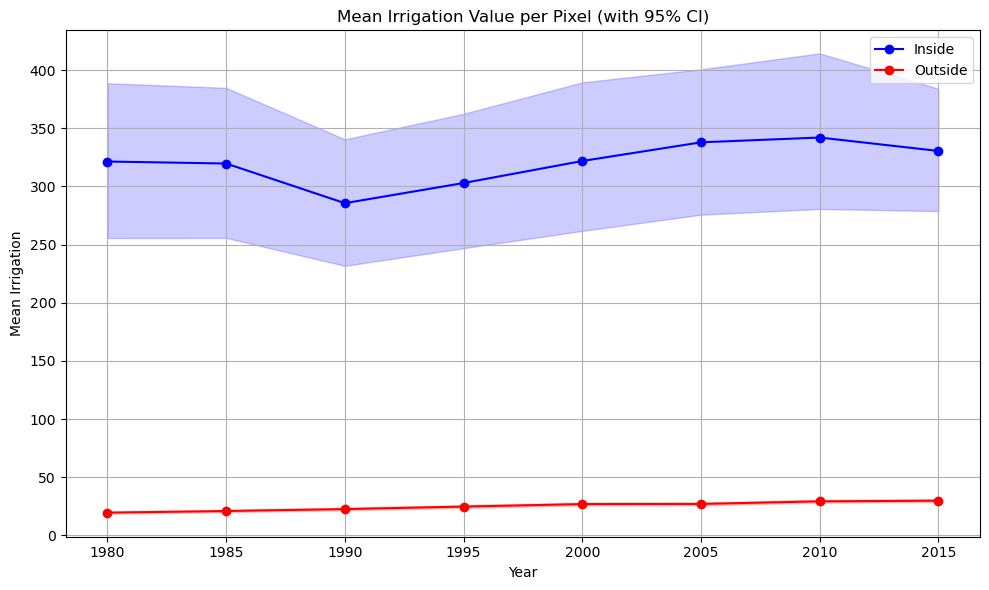

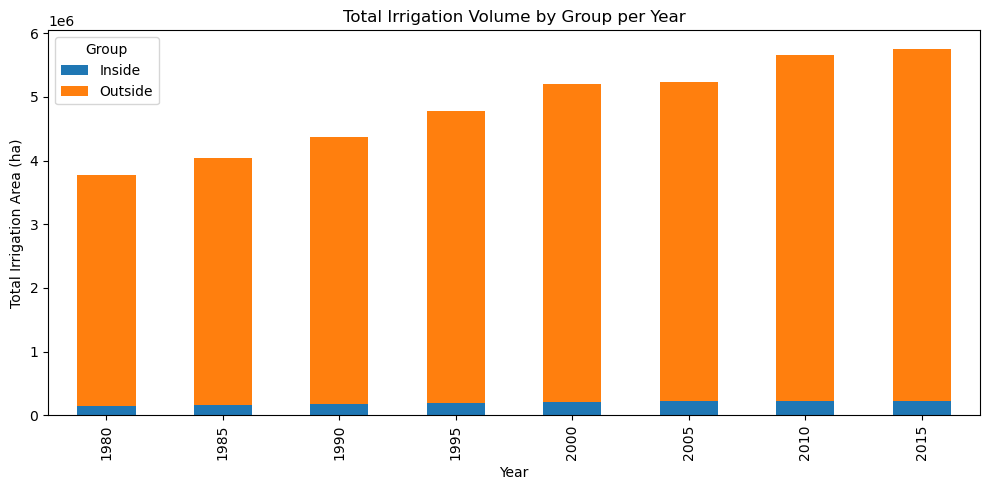

In [9]:
plt.figure(figsize=(10,6))
for group, color in [("Inside", 'blue'), ("Outside", 'red')]:
    group_df = df_boot[df_boot['Group'] == group]
    plt.plot(group_df['Year'], group_df['Mean'], label=group, marker='o', color=color)
    plt.fill_between(group_df['Year'], group_df['CI_Low'], group_df['CI_High'], alpha=0.2, color=color)
plt.legend()
plt.title("Mean Irrigation Value per Pixel (with 95% CI)")
plt.xlabel("Year")
plt.ylabel("Mean Irrigation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Build a long-form DataFrame containing all irrigation pixel values, grouped by year and location (Inside/Outside)
records = []
for year in years:
    for val in inside_pixels_dict[year]:
        if not np.isnan(val):
            records.append({'Year': year, 'Group': 'Inside', 'Irrigation': val})
    for val in outside_pixels_dict[year]:
        if not np.isnan(val):
            records.append({'Year': year, 'Group': 'Outside', 'Irrigation': val})

df_all = pd.DataFrame(records)

# Total irrigation area by group and year as stacked bar chart
summary_by_group = df_all.groupby(['Year', 'Group'])['Irrigation'].sum().reset_index()
pivoted = summary_by_group.pivot(index='Year', columns='Group', values='Irrigation')
pivoted['Total'] = pivoted['Inside'] + pivoted['Outside']
pivoted['% Inside'] = pivoted['Inside'] / pivoted['Total']

pivoted[['Inside', 'Outside']].plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title("Total Irrigation Volume by Group per Year")
plt.ylabel("Total Irrigation Area (ha)")
plt.tight_layout()
plt.show()


### 10. Cliff's Interpretation

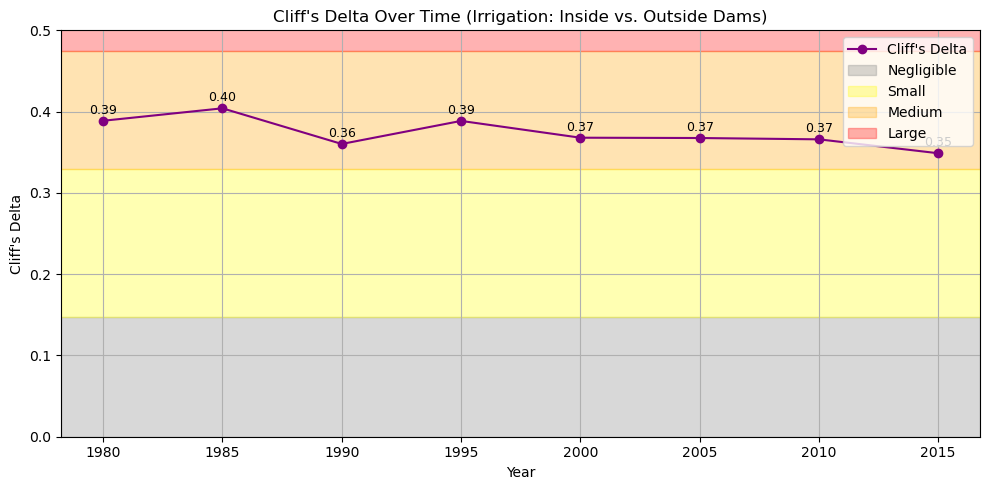

In [ ]:
def interpret_effect_size(delta):
    abs_d = abs(delta)
    if abs_d < 0.147: return 'Negligible'
    elif abs_d < 0.33: return 'Small'
    elif abs_d < 0.474: return 'Medium'
    else: return 'Large'

df_tests['Effect_Size_Label'] = df_tests['Cliff'].apply(interpret_effect_size)

plt.figure(figsize=(10, 5))
plt.plot(df_tests['Year'], df_tests['Cliff'], marker='o', color='purple', label="Cliff's Delta")

# Effect size interpretation bands
plt.axhspan(0.0, 0.147, color='grey', alpha=0.3, label='Negligible')
plt.axhspan(0.147, 0.33, color='yellow', alpha=0.3, label='Small')
plt.axhspan(0.33, 0.474, color='orange', alpha=0.3, label='Medium')
plt.axhspan(0.474, 1.0, color='red', alpha=0.3, label='Large')

# Annotate each point with delta value
for _, row in df_tests.iterrows():
    plt.text(row['Year'], row['Cliff'] + 0.005, f"{row['Cliff']:.2f}", 
             ha='center', va='bottom', fontsize=9)

plt.ylim(0, 0.5)
plt.xlabel('Year')
plt.ylabel("Cliff's Delta")
plt.title("Cliff's Delta Over Time (Irrigation: Inside vs. Outside Dams)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()